In [31]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from cvxpy import *
from sklearn.preprocessing import StandardScaler
import cv2
import nimfa
import matplotlib.pyplot as plt 

def factorization(V, list_of_arrays):
    snmf = nimfa.Snmf(V, seed="random_c", rank=4, max_iter=20, version='r', eta=1.)
    snmf_fit = snmf()
    globals()[list_of_arrays[0]] = snmf.basis()
    globals()[list_of_arrays[1]] = snmf.coef()

In [32]:
list_images = []
list_tags=['sky','water','forest','ice','bear','lion','elephant','pyramid','mountains']
n_of_images = 50
n_of_features = 6
for i in range(1,n_of_images+1):
    list_images.append('image_%s.jpg'%i)

a = 0
X = np.empty([n_of_images,n_of_features])
for i in list_images:
    image = cv2.imread(i)
    (means,stds) = cv2.meanStdDev(image)
    stats = np.concatenate([means, stds]).flatten()
    X[a] = stats
    a +=1

In [33]:
k=5
for i in range(0,k+1):
    globals()['factor_string%s' %i] = ['W%s'%i,'H%s'%i]

In [34]:
n_of_tags = 9
df = pd.read_csv("tagdata.csv")
print(df.head())


D = df[['sky','water','forest','ice','bear','lion','elephant','pyramid','mountains']].values

factorization(D,factor_string0)

        images  sky  water  forest  ice  bear  lion  elephant  pyramid  \
0  image_1.jpg    0      0       0    1     1     0         0        0   
1  image_2.jpg    0      0       1    0     0     1         0        0   
2  image_3.jpg    0      1       0    0     0     0         0        0   
3  image_4.jpg    1      0       0    0     0     0         0        1   
4  image_5.jpg    0      0       1    0     0     0         1        0   

   mountains  
0          0  
1          0  
2          0  
3          0  
4          0  


In [35]:
kmeans = KMeans(n_clusters=k, random_state=0).fit(W0)
kmeans.labels_

array([1, 2, 0, 4, 3, 3, 4, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 0,
       0, 2, 2, 2, 3, 3, 0, 3, 3, 3, 3, 3, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4,
       0, 0, 4, 4, 4, 4], dtype=int32)

In [36]:
rows=[]
for i in range(k):
    rows.append(np.count_nonzero(kmeans.labels_ == i))

tag_cluster_names=[]                                   # clustering D matrix
feature_cluster_names=[]
for i in range(k):
    globals()['D%s' % str(i+1)] = np.empty([rows[i],n_of_tags])
    tag_cluster_names.append('D%s' % str(i+1))
    globals()['X%s' % str(i+1)] = np.empty([rows[i],n_of_features])
    feature_cluster_names.append('X%s' % str(i+1))

c,d,e,f,g = 0,0,0,0,0
for i in range(W0.shape[0]):                    
    if kmeans.labels_[i] == 0:
        D1[c] = D[i]
        c+= 1
    elif kmeans.labels_[i] == 1:
        D2[d] = D[i]
        d+= 1 
    elif kmeans.labels_[i] == 2:
        D3[e] = D[i]
        e+= 1
    elif kmeans.labels_[i] == 3:
        D4[f] = D[i]
        f+= 1
    elif kmeans.labels_[i] == 4:
        D5[g] = D[i]
        g+= 1

c,d,e,f,g = 0,0,0,0,0
for i in range(W0.shape[0]):                    
    if kmeans.labels_[i] == 0:
        X1[c] = X[i]
        c+= 1
    elif kmeans.labels_[i] == 1:
        X2[d] = X[i]
        d+= 1   
    elif kmeans.labels_[i] == 2:
        X3[e] = X[i]
        e+= 1
    elif kmeans.labels_[i] == 3:
        X4[f] = X[i]
        f+= 1
    elif kmeans.labels_[i] == 4:
        X5[g] = X[i]
        g+= 1

In [37]:
for i in range(1,k+1):                              # factorization of all clusters
    factorization(globals()['D%s'% i], globals()['factor_string%s' % i])

In [38]:
for i in range(k):
    globals()['S%s' % str(i+1)] = np.empty([rows[i],rows[i]])
    globals()['T%s' % str(i+1)] = np.empty([n_of_tags,n_of_tags])
    globals()['Y%s' % str(i+1)] = np.empty([rows[i],n_of_tags])

In [39]:
def reconstruction_s(arr1):
    S = Variable(shape = (arr1.shape[0],arr1.shape[0]))
    objective = Minimize ((norm(arr1 - S @ arr1,"fro"))**2 + norm(S,1))
    constraints = [ trace(S) == 0, S >=0 ]
    problem = Problem(objective, constraints)
    problem.solve(solver=SCS)
    return S.value

In [40]:
def reconstruction_t(arr1):
    T = Variable(shape = (arr1.shape[1],arr1.shape[1]))
    objective = Minimize ((norm(arr1 - arr1 @ T,"fro"))**2 + norm(T,1))
    constraints = [ trace(T) == 0, T >=0 ]
    problem = Problem(objective, constraints)
    problem.solve(solver=SCS)
    return T.value

In [41]:
for i in range(1,k+1):
    globals()['S%s'%i] = reconstruction_s(globals()['X%s'%i])
    globals()['W_new%s'%i] = np.dot(globals()['S%s'%i],globals()['W%s'%i])  
    globals()['T%s'%i] = reconstruction_t(globals()['D%s'%i])
    globals()['H_new%s'%i] = np.dot(globals()['H%s'%i],globals()['T%s'%i])
    globals()['Y%s'%i] = np.dot(globals()['W_new%s'%i],globals()['H_new%s'%i])

In [42]:
c,d,e,f,g = 0,0,0,0,0
Y = np.empty(D.shape)
for i in range(D.shape[0]):
    if kmeans.labels_[i] == 0:
        Y[i] = Y1[c]
        c+=1
    elif kmeans.labels_[i] == 1:
        Y[i] = Y2[d]
        d+=1
    elif kmeans.labels_[i] == 2:
        Y[i] = Y3[e]
        e+=1
    elif kmeans.labels_[i] == 3:
        Y[i] = Y4[f]
        f+=1
    elif kmeans.labels_[i] == 4:
        Y[i] = Y5[g]
        g+=1

In [43]:
np.set_printoptions(suppress=True)
Y[Y<0] = 0
Y[Y>1] = 1

In [44]:
DF = np.maximum(D,Y)
DF

array([[0.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.28684345],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.39328015, 1.        ],
       [0.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],


In [45]:
df1 = pd.DataFrame(data=DF,index=list_images,columns=list_tags)
df1.round(5)

,sky,water,forest,ice,bear,lion,elephant,pyramid,mountains
image_1.jpg,0.0,0.0,0.00000,1.0000,1.00000,0.0,0.0,0.00000,0.00000
image_2.jpg,0.0,0.0,1.00000,0.0000,0.00000,1.0,0.0,0.00000,0.00000
image_3.jpg,0.0,1.0,0.00000,0.0000,0.00000,0.0,0.0,0.00000,0.00000
image_4.jpg,1.0,0.0,0.00000,0.0000,0.00000,0.0,0.0,1.00000,0.28684
image_5.jpg,0.0,0.0,1.00000,0.0000,0.00000,0.0,1.0,0.00000,0.00000
image_6.jpg,0.0,0.0,1.00000,0.0000,0.00000,0.0,1.0,0.00000,0.00000
image_7.jpg,1.0,0.0,0.00000,0.0000,0.00000,0.0,0.0,0.39328,1.00000
image_8.jpg,0.0,0.0,0.00000,1.0000,1.00000,0.0,0.0,0.00000,0.00000
image_9.jpg,0.0,0.0,1.00000,0.0000,0.00000,1.0,0.0,0.00000,0.00000
image_10.jpg,1.0,0.0,0.00000,0.0000,0.00000,0.0,0.0,0.32395,1.00000


In [46]:
#images that are partially tagged are image_3, 13, 16, 22, 23, 28, 29, 30, 34, 37, 38, 41, 45, 46, 50
# 13(50), 16(36), 22(7), 23(13), 28(70), 29(70), 30(70), 34(67), 37(37), 38(44), 41(91), 45(70), 46(76), 50(51)  
def search(num):
    print("The tag values of image_{0} before\n".format(num))
    print(df.loc[num-1, : ])
    print("\nThe tag values of image_{0} after tag completion\n".format(num))
    print((df1.loc['image_%d.jpg'%num, : ]).round(5))

In [54]:
search(41)

The tag values of image_41 before

images       Image_41.jpg
sky                     1
water                   0
forest                  0
ice                     0
bear                    0
lion                    0
elephant                0
pyramid                 0
mountains               0
Name: 40, dtype: object

The tag values of image_41 after tag completion

sky          1.00000
water        0.00000
forest       0.00000
ice          0.00000
bear         0.00000
lion         0.00000
elephant     0.00000
pyramid      0.47644
mountains    0.55586
Name: image_41.jpg, dtype: float64


In [48]:
def error(ita,gamma,beta):
    loss=[]
    for i in range(1,k+1):
        temp1 = globals()['D%s'%i] - np.dot(globals()['W_new%s'%i],globals()['H_new%s'%i])
        first = (np.linalg.norm(temp1,ord='fro'))**2
        temp2 = globals()['W%s'%i] - globals()['W_new%s'%i]
        second = (np.linalg.norm(temp2,ord='fro'))**2
        temp3 = globals()['H%s'%i] - globals()['H_new%s'%i]
        third = (np.linalg.norm(temp3,ord='fro'))**2
        fourth = np.linalg.norm(globals()['H_new%s'%i],ord=1)
        final = first + ita*second + gamma*third + 2*beta*fourth
        loss.append(final)
    return loss

In [49]:
LOSS = error(1,2,0.5)

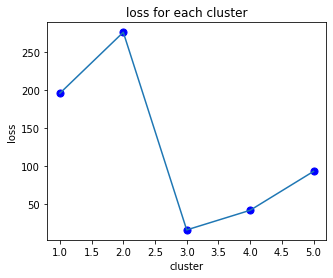

In [50]:
x = [1,2,3,4,5]
y = LOSS

#plot
fig = plt.figure(figsize=(5, 4)) 
plt.plot(x, y) 
plt.scatter(x,y,color='b',s=50)
plt.xlabel('cluster') 
plt.ylabel('loss') 
plt.title('loss for each cluster') 
plt.show()